# Cashflow Forecasting

## Setting up

This notebook sets out the results of the cashflow forecasting that I have done. The base of the model that I have created is the `_run_forecast_internal` function - this acts directly on numpy arrays and takes the following arguments:
- `n_months` - number of months to forecast over
- `loans` - this is a "number of loans" x 6 array that comprises static information on the loans at the start of the forecast (outstanding balance, remaining term, time to reversion, fixed pre-reversion and post-reversion margin rates and whether the loan is interest only)
- `cpr` - a "number of loans" x "forecast months" array that contains monthly conditional pre-payment probabilities over the forecast period for each loan
- `cdr` - as above but for monthly conditional default probabilities
- `recovery_curve` - an array showing expected recovery by month vs time since default (not cumulative!)
- `base_rate` - an array giving the monthly BoE base rate

This function is pretty flexible, and allows modelling on a loan-by-loan basis. Further but default the returned resulting arrays are all given on a loan-by-loab basis for debugging.

For ease of use, I have wrapped this in a function `run_forecast` - this takes only the pre-processed loan data that we generated in the first notebook and a `ForecastScenario` configuration object, creates the required numpy arrays, and converts the output back to easy-to-visualize pandas dataframes of aggregated cashflows.

In [1]:
# append root directory to path so we can import from `common` - in reality this would not be
# required as we would store the modules in `common` as some centrally managed library 

import sys
import os

notebook_root_dir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(notebook_root_dir)

In [2]:
# do imports
import datetime as dt
from timeit import default_timer as timer

import pandas as pd
from matplotlib import pyplot as plt

from common.forecasting import ForecastScenario, run_forecast, convert_forecast_results_to_df
from common.plotting import plot_forecast_results

In [3]:
# read in the processed loan data from our first notebook
processed_loan_data = pd.read_csv("../data/processed_case_study_data.csv", index_col=0)
processed_loan_data["date"] = pd.to_datetime(processed_loan_data["date"])

# read in the smm/mdr curve data from our second notebook (need to rescale back to %)
product_1_smm_curve = pd.read_csv("../data/product_1_by_time_to_reversion_smm.csv", index_col=0).iloc[:, 0] / 100
product_2_smm_curve = pd.read_csv("../data/product_2_by_time_to_reversion_smm.csv", index_col=0).iloc[:, 0] / 100
product_1_mdr_curve = pd.read_csv("../data/product_1_by_time_to_reversion_mdr.csv", index_col=0).iloc[:, 0] / 100
product_2_mdr_curve = pd.read_csv("../data/product_2_by_time_to_reversion_mdr.csv", index_col=0).iloc[:, 0] / 100

# finally read in the recovery curve - for these stats we want the amount recovered each time (ie not
# cumulative) so we need to diff it. Also cap it all 10 months post default as seems to be no change
# after that
recovery_curve = pd.read_csv("../data/recovery_curve_2021.csv", index_col=0).iloc[:, 0] / 100
recovery_curve = recovery_curve.diff().fillna(0)
recovery_curve = recovery_curve.loc[:10]

## Forecasts

### Base case scenario

We first run our base case, using the conditional pre-payment, default and recovery values calibrated in our previous notebook. I have plotted a selection of charts to help us sense check the output. I think these look broadly as expected:
- outstanding cashflow schedule balance stays constant, at no mortgates mature over the forecast period
- the **expected** balance does decline over time, owing to the impact of defaults and pre-payments
- interest payments rise over the first ~24 years as more of the mortgages hit their reversion period
- the scheduled payments then stay constant, while again the expected payments decline slighlty owing to the impact of defaults and prepayments
- there are no principal payments
- expected default and pre-payment values broadly follow the CPR/CDR profiles observed in the previous notebook
- expected losses only kick in after month 10 (as our recovery curve is out to 10 months, after which we recognize a loss)

In [4]:
# define our forecast scenario

forecast_scenario = ForecastScenario(
    forecast_date=dt.datetime(2022, 12, 31),
    forecast_months=60,
    product_1_smm=product_1_smm_curve, 
    product_2_smm=product_2_smm_curve, 
    product_1_mdr=product_1_mdr_curve, 
    product_2_mdr=product_2_mdr_curve, 
    boe_base_rate=0.045,
    recovery_curve=recovery_curve,
    assumed_mortgage_tenor=15  # assumed all same term as the one in the example
)

In [5]:
# run forecast and time the output

t_0 = timer()

results = run_forecast(processed_loan_data, forecast_scenario)
cashflow_schedule, expected_cashflows, expected_defaults = convert_forecast_results_to_df(*results)
    
t_1 = timer()
print(f"Completed forecast in {t_1 - t_0}s")

Completed forecast in 1.2576677999895765s


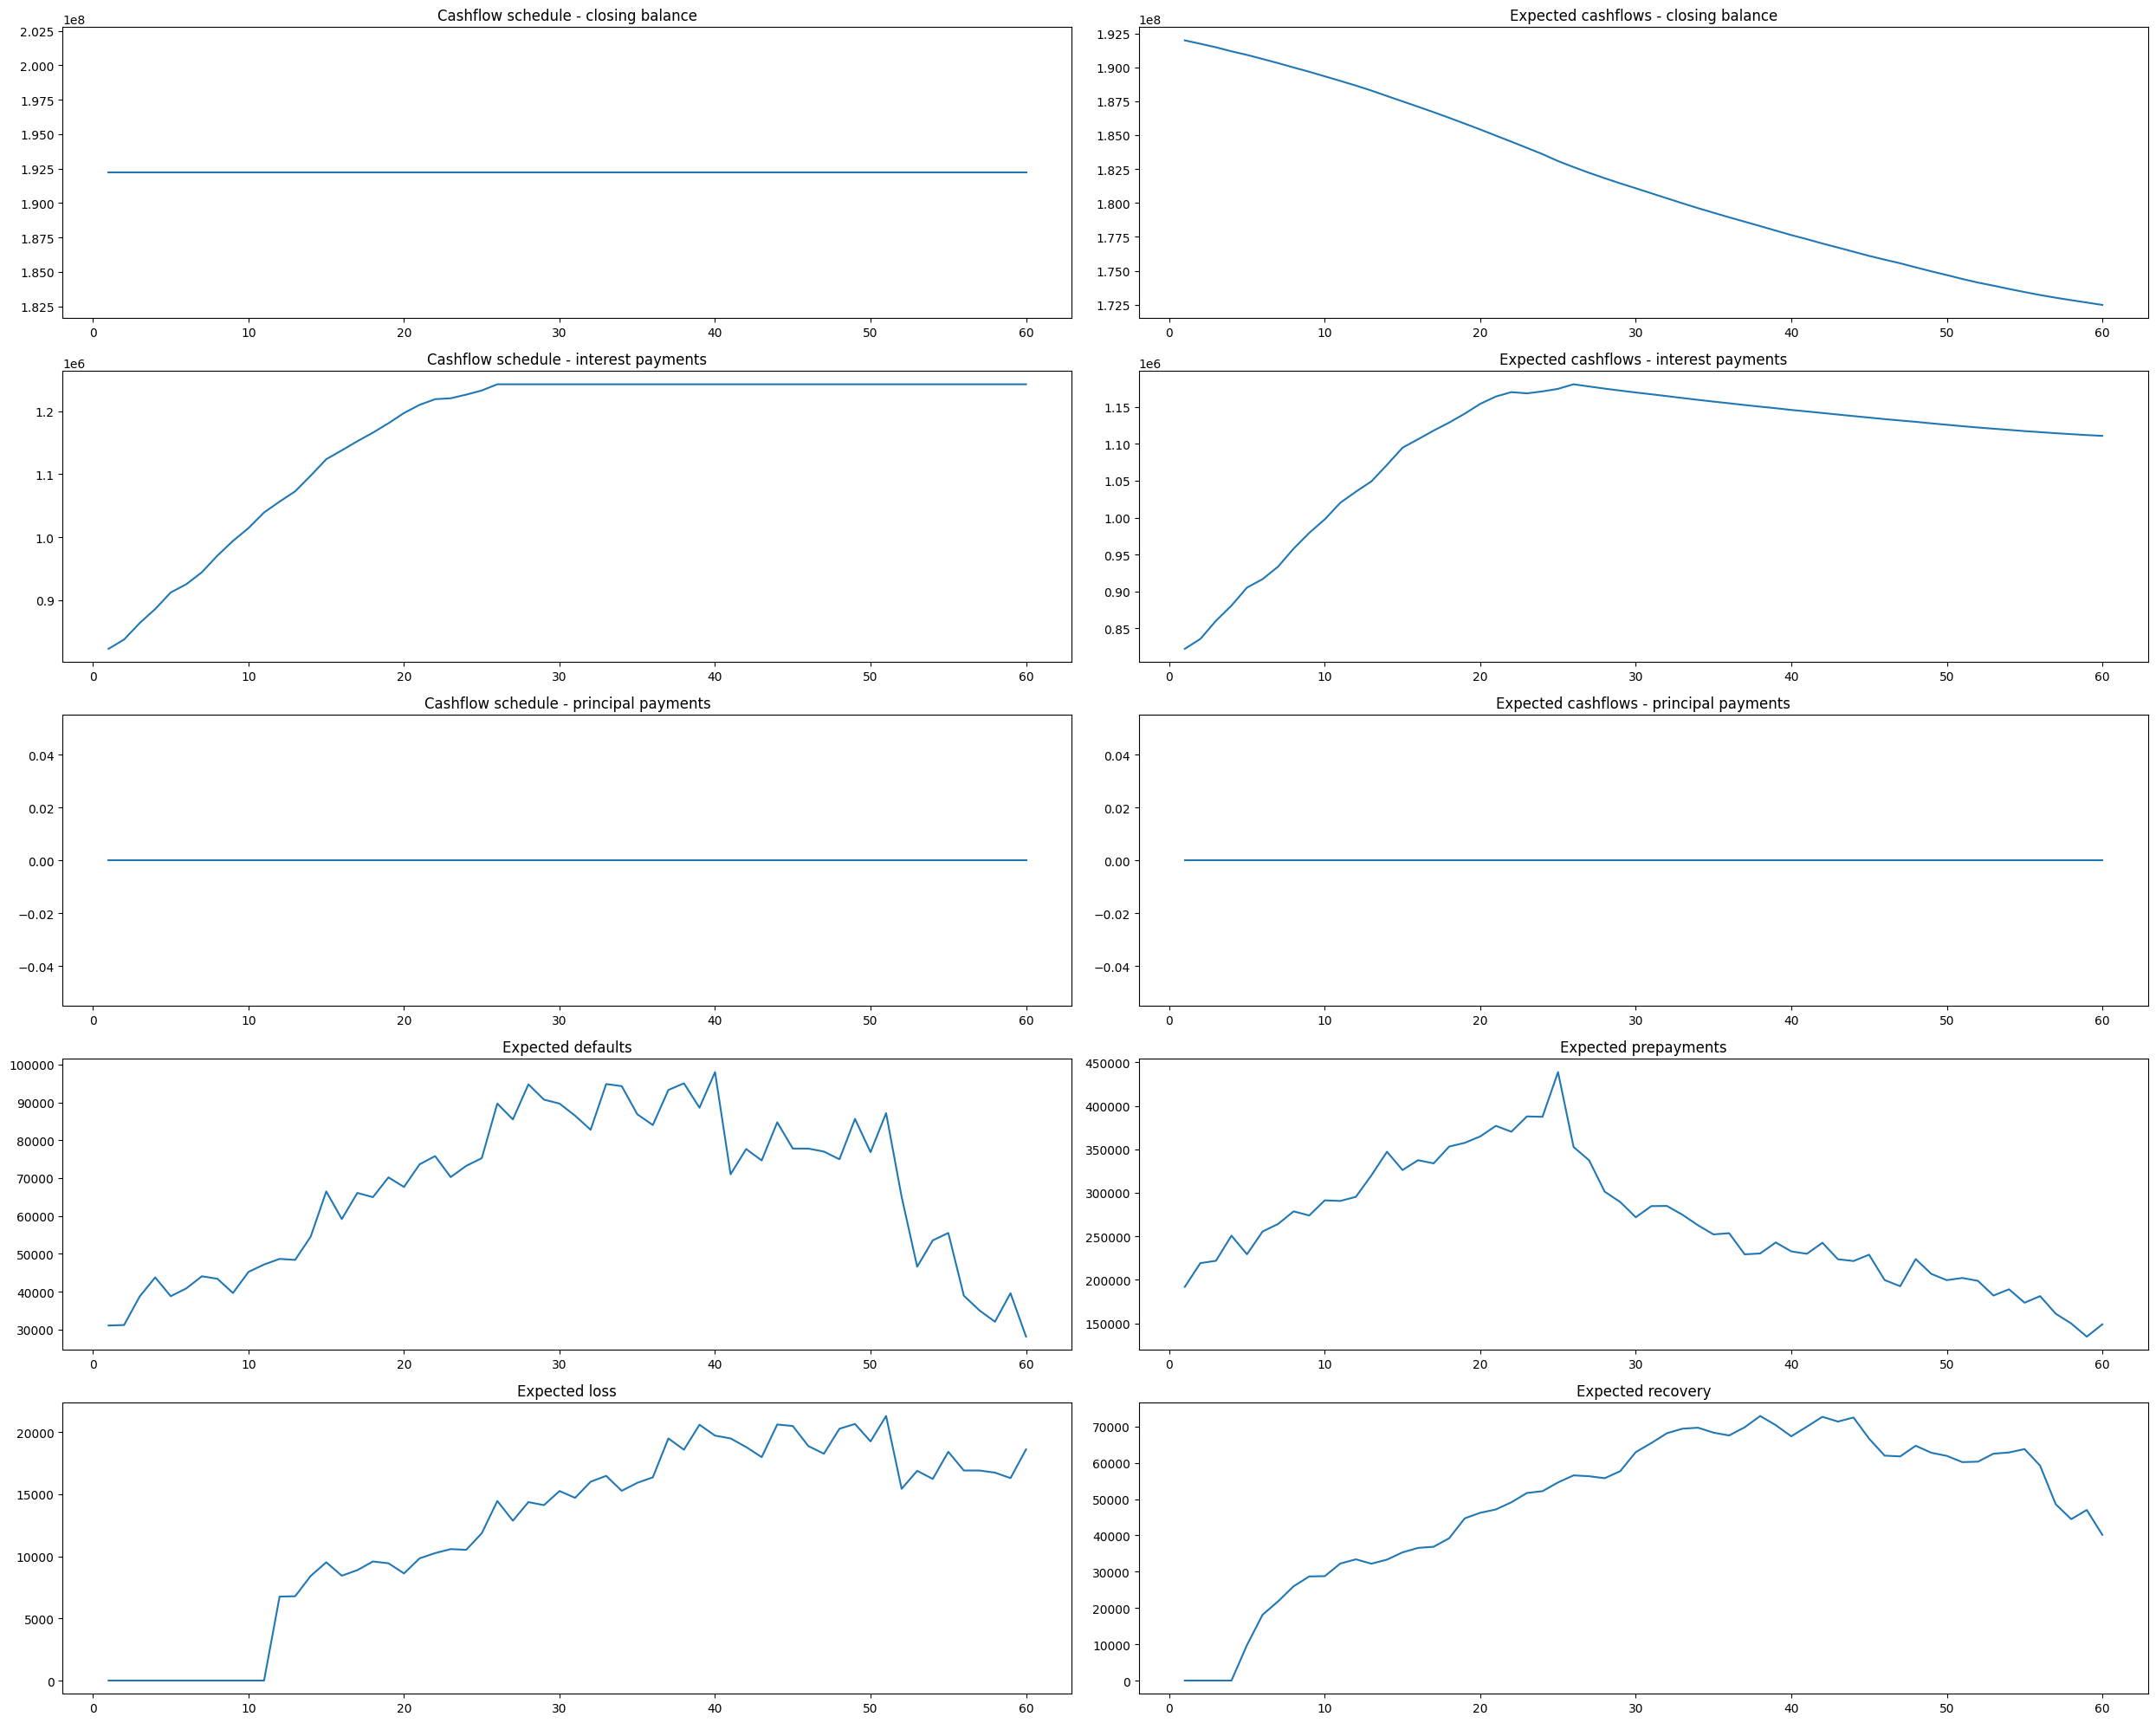

In [6]:
# plot results of forecast

plot_forecast_results(cashflow_schedule, expected_cashflows, expected_defaults)

### Base case scenario (interest and principal)

For illustration - the same portfolio of mortgages where principal as well as interest payments are due. As expected the charts below look somewhat similar but for the fact that the scheduled outstanding balance descreases over time (as principal payments are made), and we have values for the scheduled and expected principal payments.

In [7]:
# define our forecast scenario

forecast_scenario = ForecastScenario(
    forecast_date=dt.datetime(2022, 12, 31),
    forecast_months=60,
    product_1_smm=product_1_smm_curve, 
    product_2_smm=product_2_smm_curve, 
    product_1_mdr=product_1_mdr_curve, 
    product_2_mdr=product_2_mdr_curve, 
    boe_base_rate=0.045,
    recovery_curve=recovery_curve,
    assumed_mortgage_tenor=15,  # assumed all same term as the one in the example
    interest_only_mortgages=False
)

In [8]:
# run forecast and time the output

t_0 = timer()

results = run_forecast(processed_loan_data, forecast_scenario)
cashflow_schedule, expected_cashflows, expected_defaults = convert_forecast_results_to_df(*results)
    
t_1 = timer()
print(f"Completed forecast in {t_1 - t_0}s")

Completed forecast in 2.14655479999783s


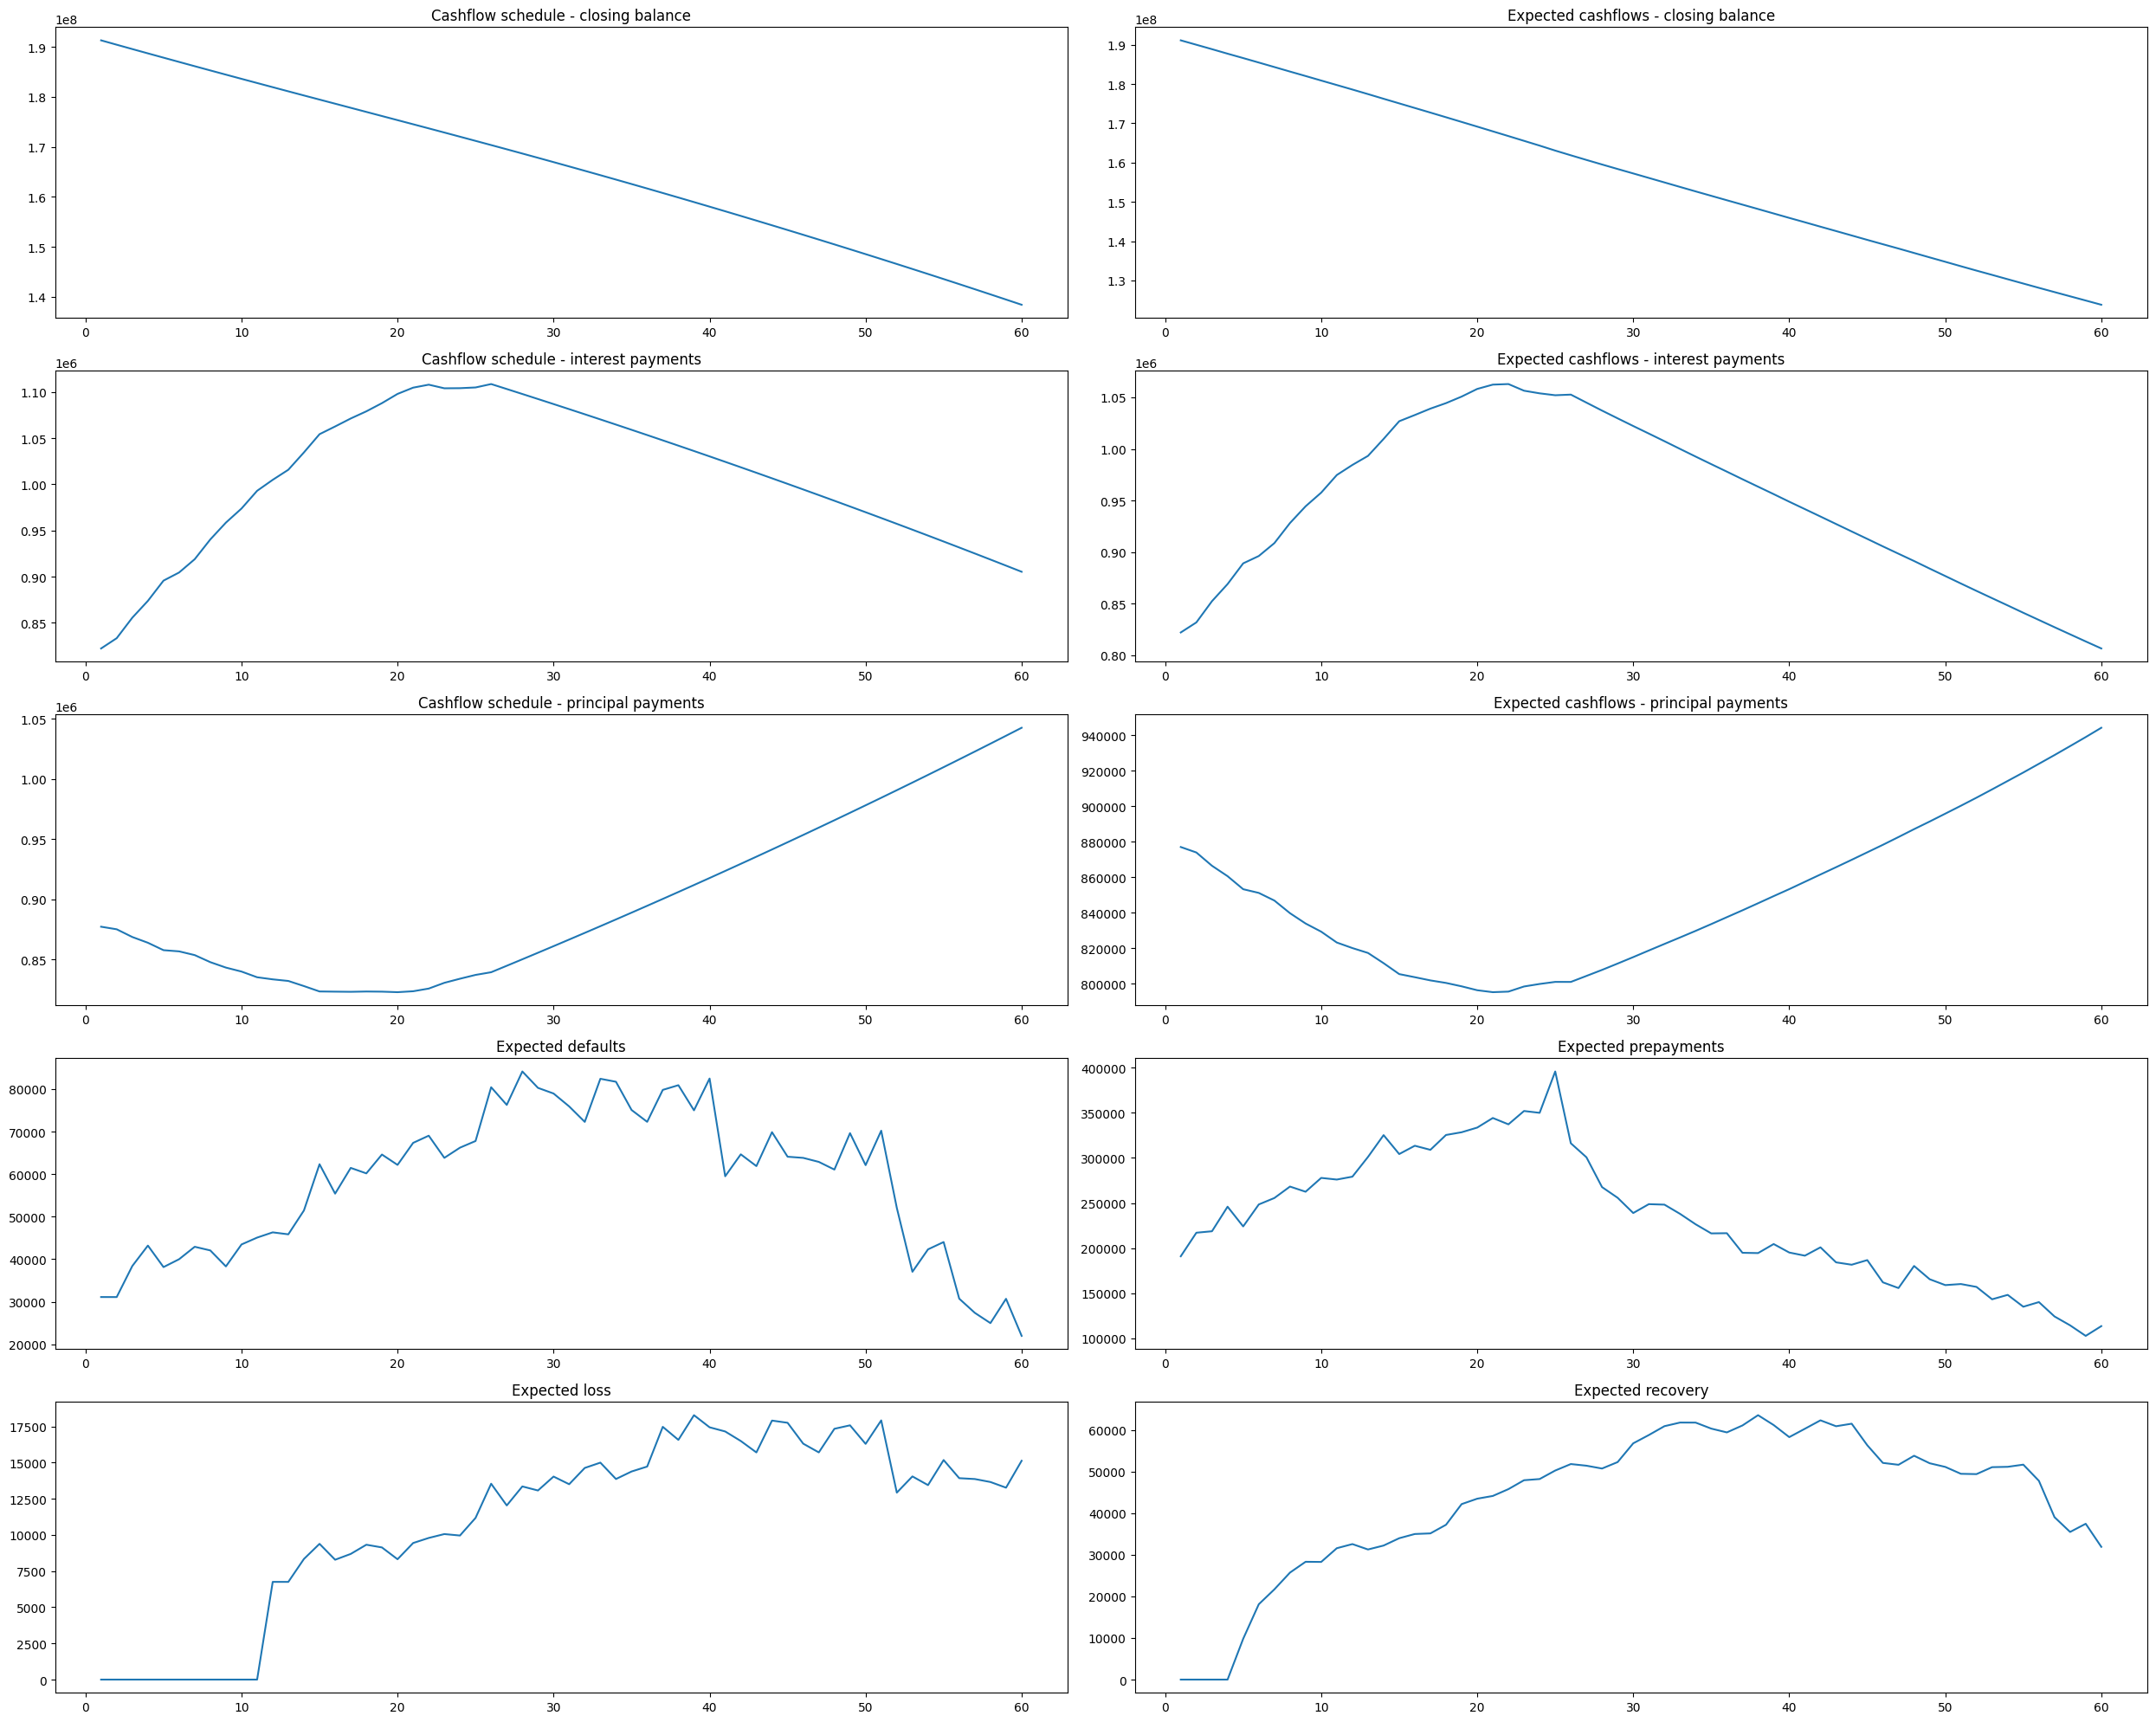

In [9]:
# plot results of forecast

plot_forecast_results(cashflow_schedule, expected_cashflows, expected_defaults)

### CPRx2 Post Reversion

Similar to our initial scenario, but we update conditional pre-payment risk such that it doubles for each mortgage post-reversion. Hopefully the below illustrates that is is relatively straightforward to run this alternative scenario.

The charts look similar to those in our initial scenario, but as we have higher pre-payment risk we see a steeper post-peak decline in expected interest payments, and a sharper decline in outstanding balance.

In [10]:
# define our forecast scenario

new_product_1_smm_curve = product_1_smm_curve.where(product_1_smm_curve.index <= 0, product_1_smm_curve * 2)
new_product_2_smm_curve = product_2_smm_curve.where(product_2_smm_curve.index <= 0, product_2_smm_curve * 2) 

forecast_scenario = ForecastScenario(
    forecast_date=dt.datetime(2022, 12, 31),
    forecast_months=60,
    product_1_smm=new_product_1_smm_curve, 
    product_2_smm=new_product_2_smm_curve, 
    product_1_mdr=product_1_mdr_curve, 
    product_2_mdr=product_2_mdr_curve, 
    boe_base_rate=0.045,
    recovery_curve=recovery_curve,
    assumed_mortgage_tenor=15  # assumed all same term as the one in the example
)

In [11]:
# run forecast and time the output

t_0 = timer()

results = run_forecast(processed_loan_data, forecast_scenario)
cashflow_schedule, expected_cashflows, expected_defaults = convert_forecast_results_to_df(*results)
    
t_1 = timer()
print(f"Completed forecast in {t_1 - t_0}s")

Completed forecast in 2.176885900000343s


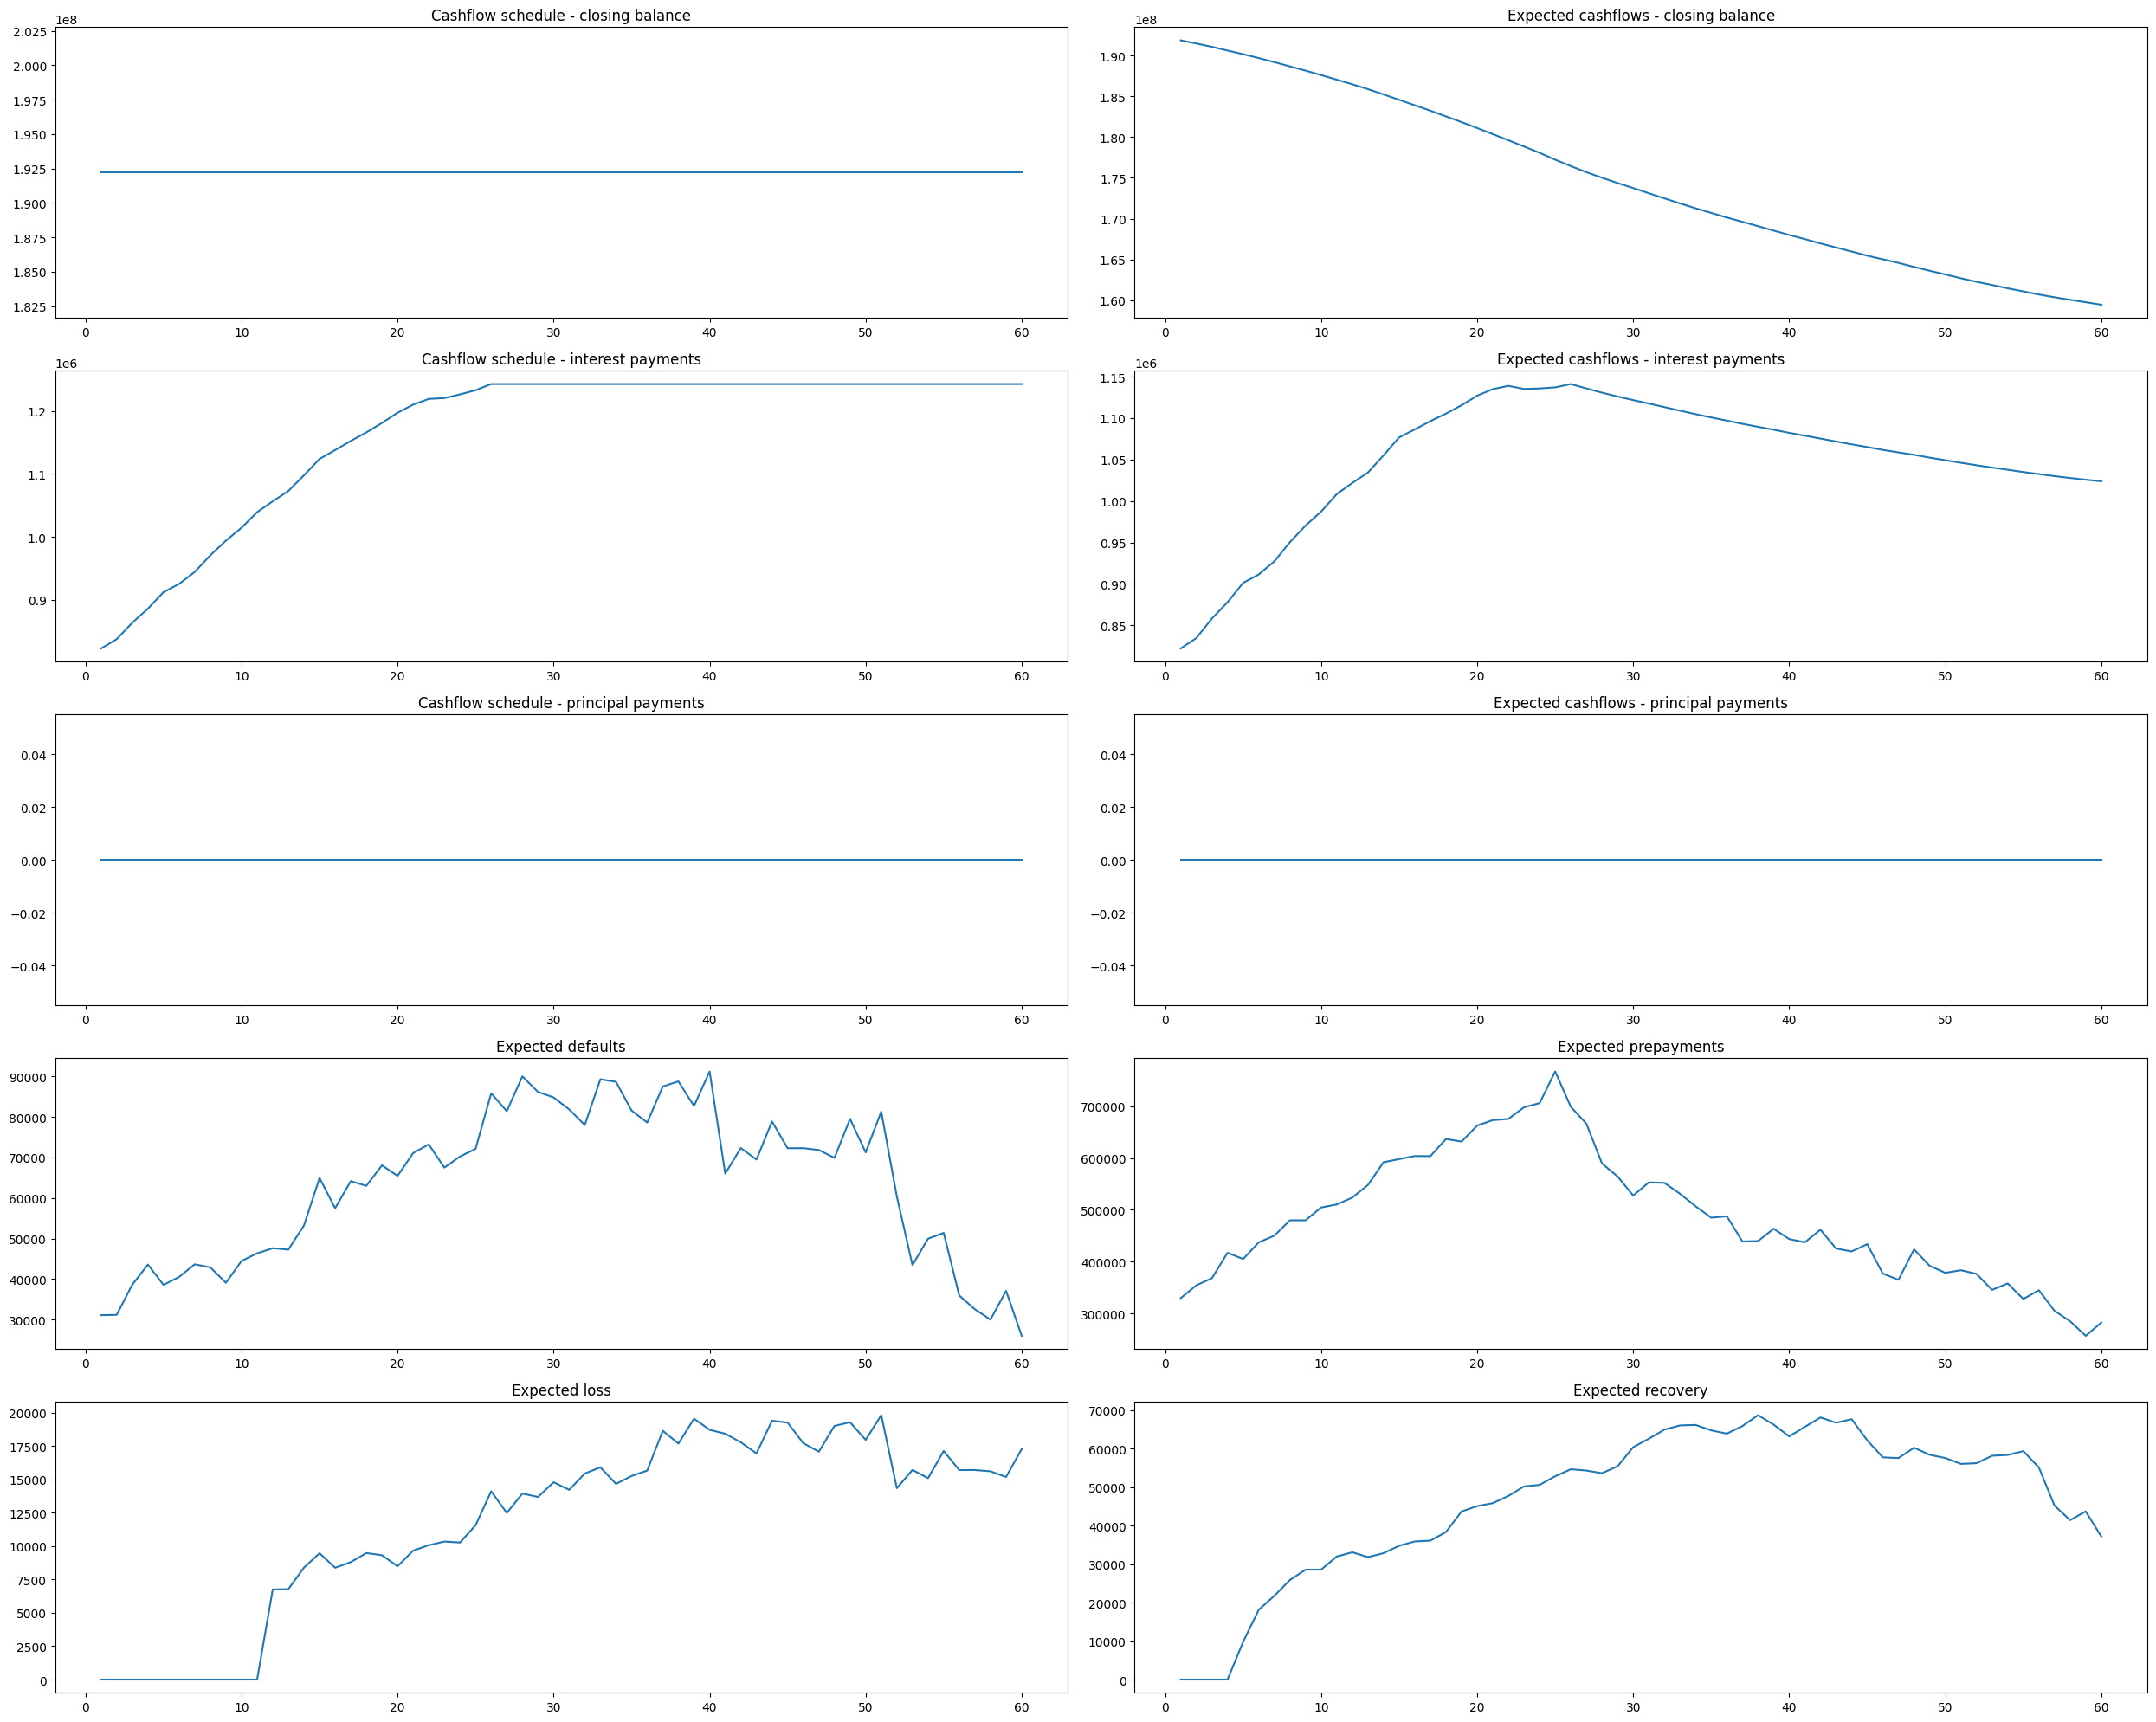

In [12]:
# plot results of forecast

plot_forecast_results(cashflow_schedule, expected_cashflows, expected_defaults)

### CPRx2 Post Reversion (product 2 only)

Similar to the above, but with the doubling of the conditional pre-payment risk only applied to mortgages of product type 2. Note that this lessens the impact, and the decline in outstanding balance and interest payments is less pronounced. I think there are two reasons for this - one is that type 2 products have a lower interest rate and comprise a smaller proportion of the overall outstanding principle, and the other is that these borrowers had a much lower conditional pre-payment risk in any case.

In [13]:
# define our forecast scenario

new_product_2_smm_curve = product_2_smm_curve.where(product_2_smm_curve.index <= 0, product_2_smm_curve * 2) 

forecast_scenario = ForecastScenario(
    forecast_date=dt.datetime(2022, 12, 31),
    forecast_months=60,
    product_1_smm=product_1_smm_curve, 
    product_2_smm=new_product_2_smm_curve, 
    product_1_mdr=product_1_mdr_curve, 
    product_2_mdr=product_2_mdr_curve, 
    boe_base_rate=0.045,
    recovery_curve=recovery_curve,
    assumed_mortgage_tenor=15  # assumed all same term as the one in the example
)

In [14]:
# run forecast and time the output

t_0 = timer()

results = run_forecast(processed_loan_data, forecast_scenario)
cashflow_schedule, expected_cashflows, expected_defaults = convert_forecast_results_to_df(*results)
    
t_1 = timer()
print(f"Completed forecast in {t_1 - t_0}s")

Completed forecast in 2.214182499999879s


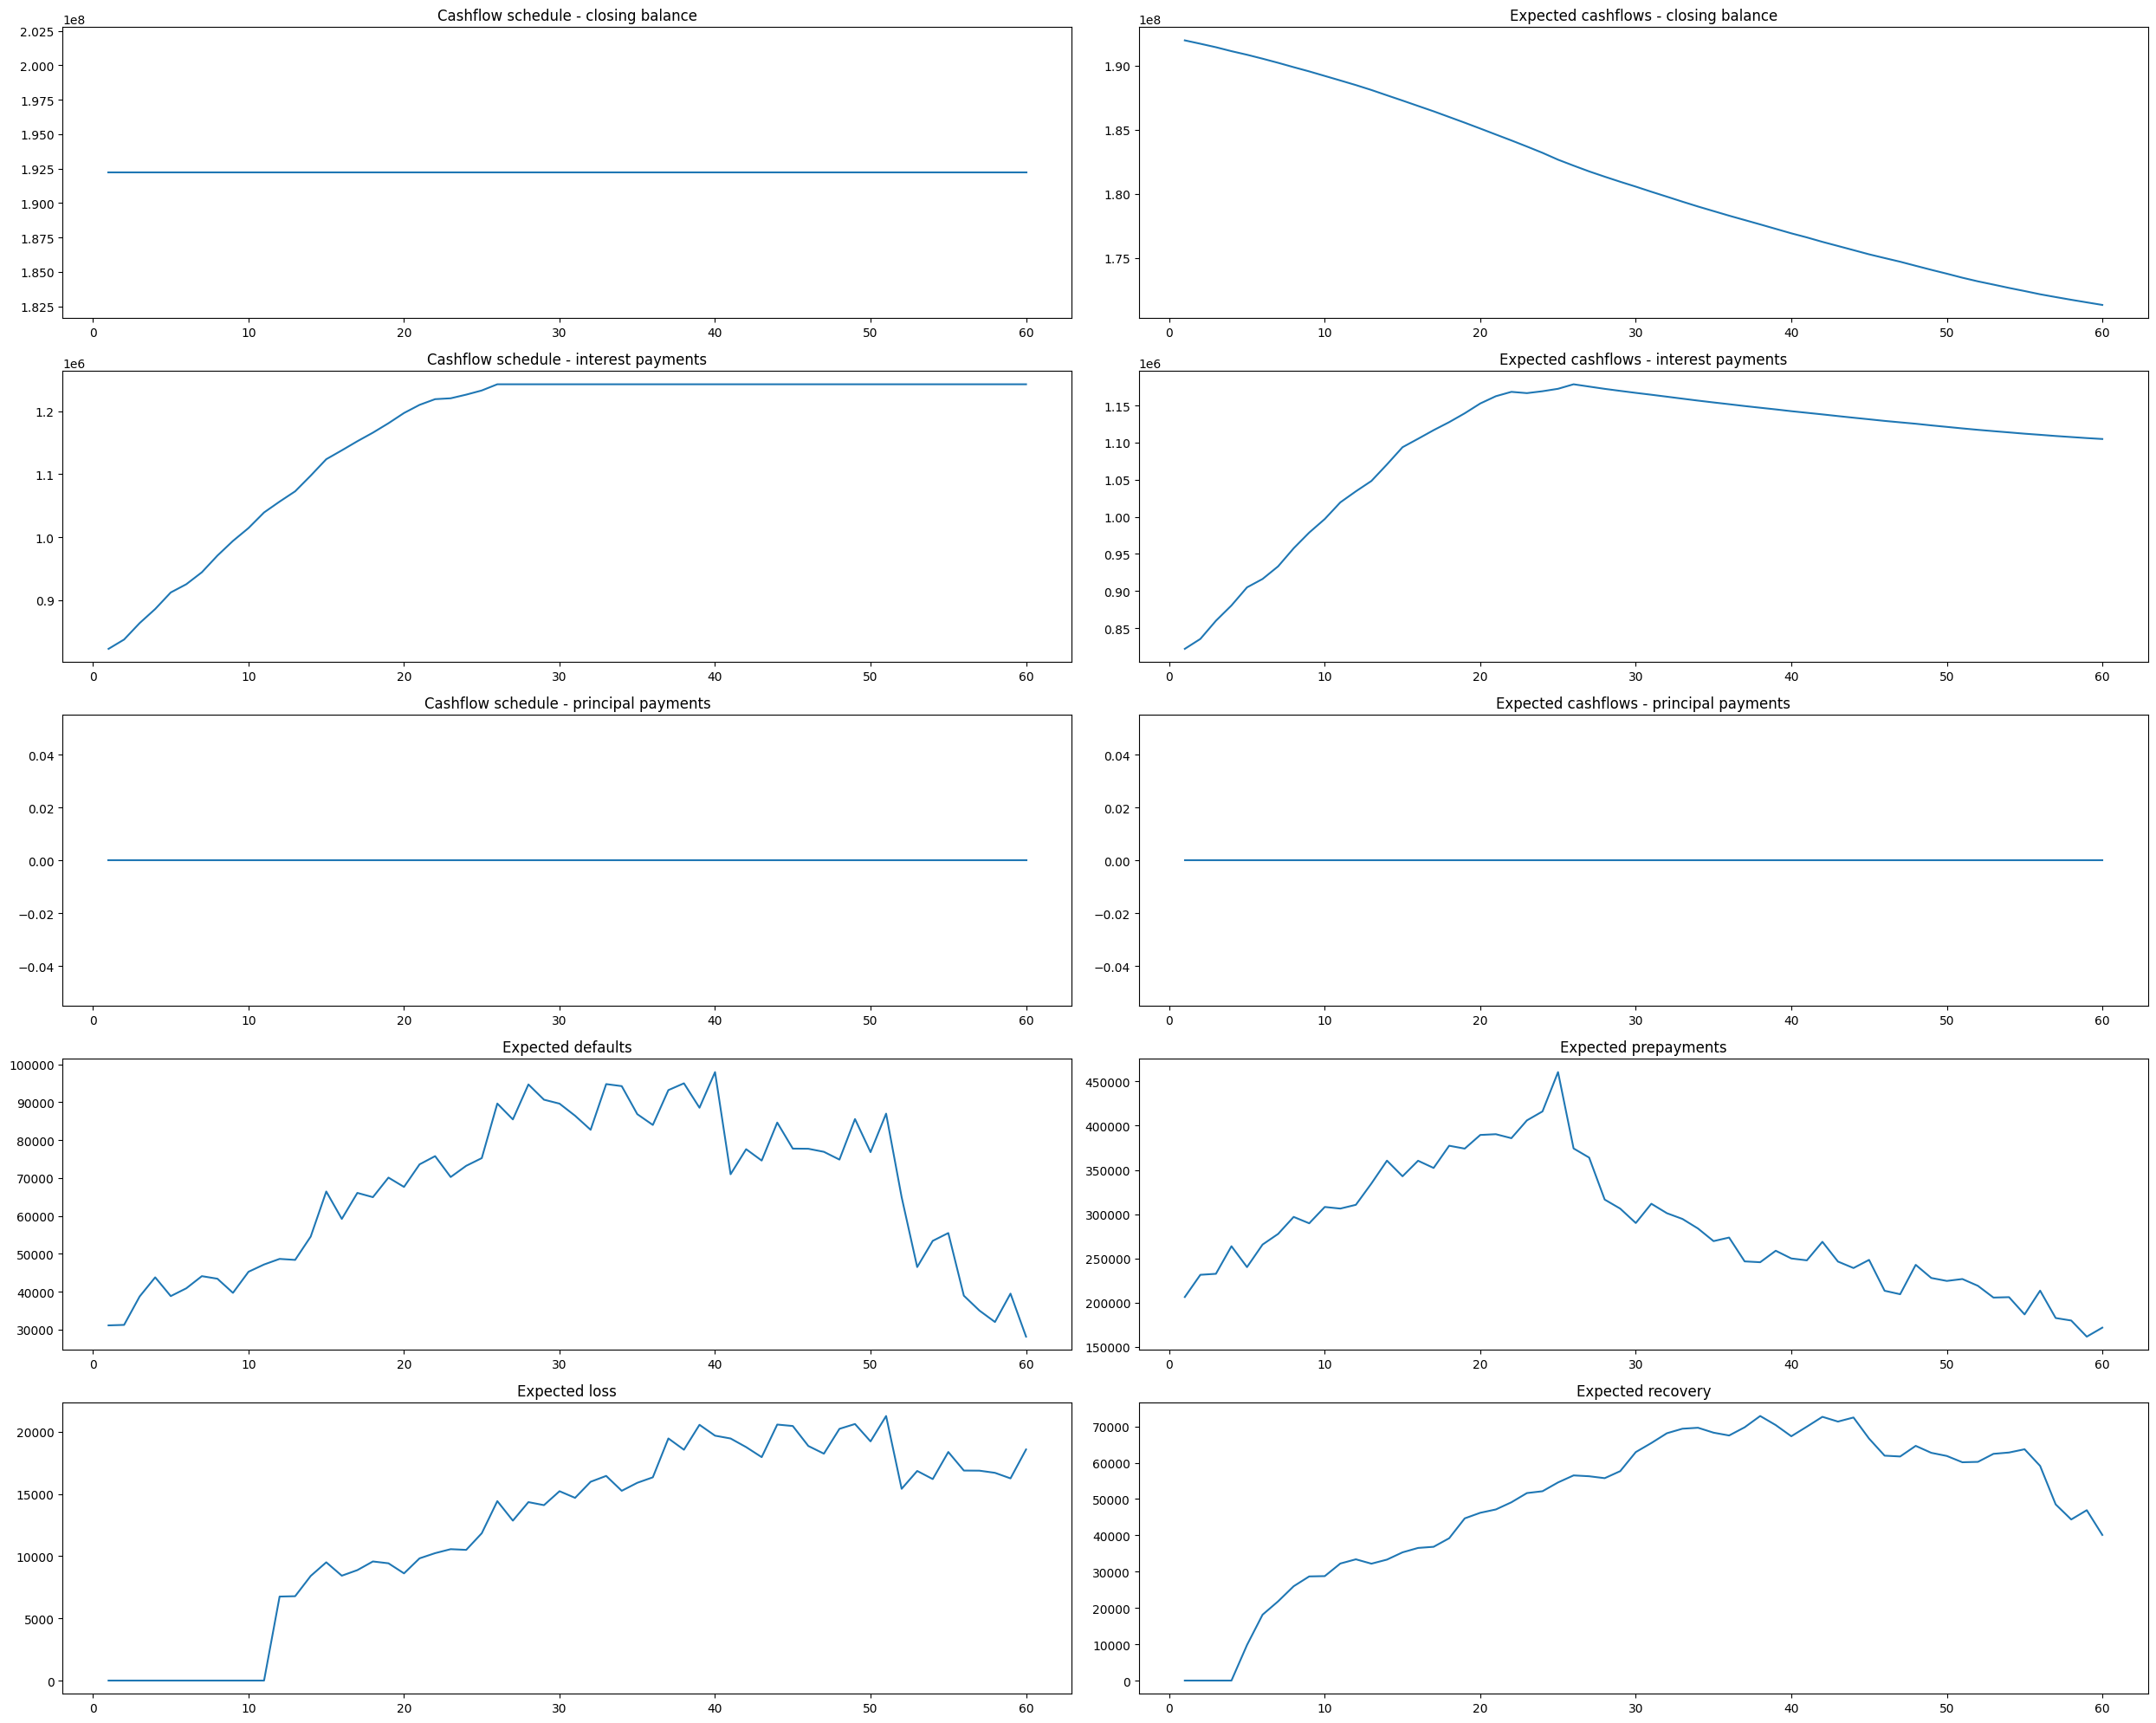

In [15]:
# plot results of forecast

plot_forecast_results(cashflow_schedule, expected_cashflows, expected_defaults)

### CPR 100% Post Reversion (product 1 only)

Here we assume that all borrowers on product 1 mortgages pre-pay upon reversion. As expected, this greatly reduces the **expected** outstanding balance and interest rate payments over the first 24 months, as the mortgages hit their reversion point and pre-pay. After that pre-payments are negligeble, in line with our understanding of product 2 mortgages.

In [16]:
# define our forecast scenario

new_product_1_smm_curve = product_1_smm_curve.where(product_1_smm_curve.index <= 0, 1) 

forecast_scenario = ForecastScenario(
    forecast_date=dt.datetime(2022, 12, 31),
    forecast_months=60,
    product_1_smm=new_product_1_smm_curve, 
    product_2_smm=product_2_smm_curve, 
    product_1_mdr=product_1_mdr_curve, 
    product_2_mdr=product_2_mdr_curve, 
    boe_base_rate=0.045,
    recovery_curve=recovery_curve,
    assumed_mortgage_tenor=15  # assumed all same term as the one in the example
)

In [17]:
# run forecast and time the output

t_0 = timer()

results = run_forecast(processed_loan_data, forecast_scenario)
cashflow_schedule, expected_cashflows, expected_defaults = convert_forecast_results_to_df(*results)
    
t_1 = timer()
print(f"Completed forecast in {t_1 - t_0}s")

Completed forecast in 2.167648400005419s


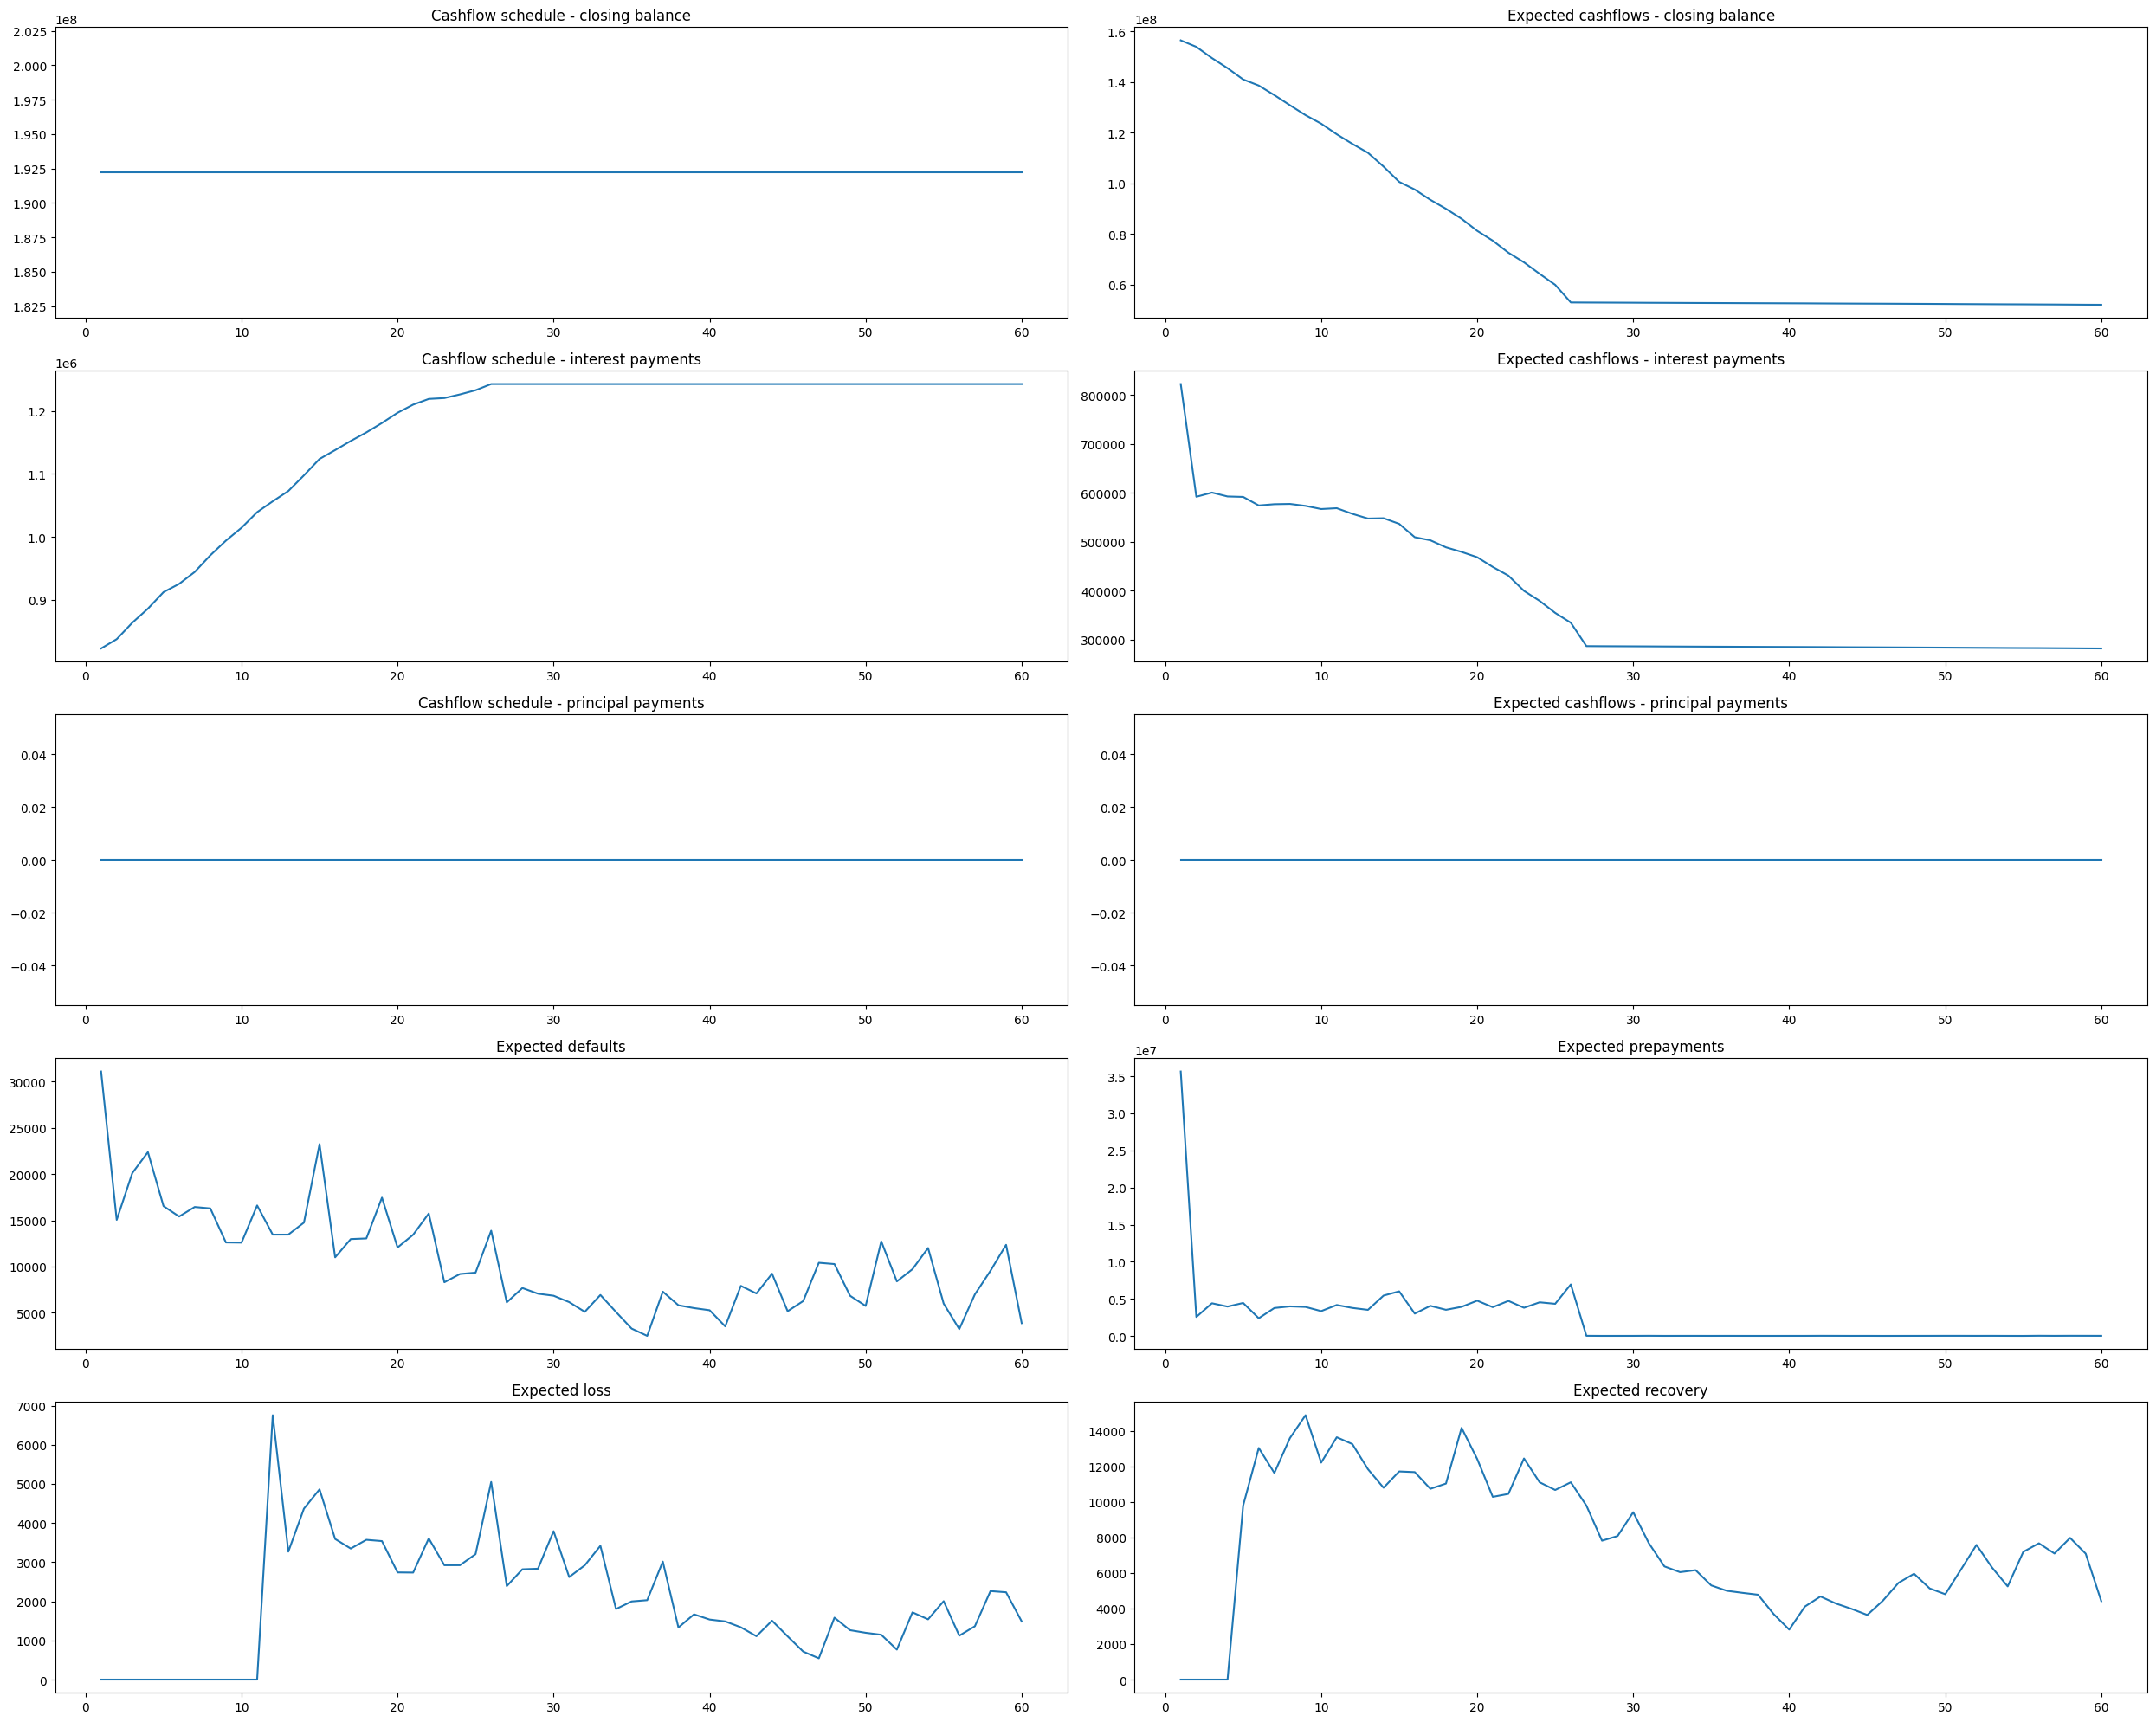

In [18]:
# plot results of forecast

plot_forecast_results(cashflow_schedule, expected_cashflows, expected_defaults)

### Linear recoveries over 24 months

Hopefully this illustrates that is is also straight-forward to change our recovery assumptions. As expected, the graphs are little changed from the base case except the recovery curve is of course much smoother, and we only see losses realized after the full 2 year period.

In [19]:
# define our forecast scenario

new_recovery_curve = pd.Series([0] + [0.8 / 24] * 24)  # linear recovery to 2021 80% max over 2 years

forecast_scenario = ForecastScenario(
    forecast_date=dt.datetime(2022, 12, 31),
    forecast_months=60,
    product_1_smm=product_1_smm_curve, 
    product_2_smm=product_2_smm_curve, 
    product_1_mdr=product_1_mdr_curve, 
    product_2_mdr=product_2_mdr_curve, 
    boe_base_rate=0.045,
    recovery_curve=new_recovery_curve,
    assumed_mortgage_tenor=15  # assumed all same term as the one in the example
)

In [20]:
# run forecast and time the output

t_0 = timer()

results = run_forecast(processed_loan_data, forecast_scenario)
cashflow_schedule, expected_cashflows, expected_defaults = convert_forecast_results_to_df(*results)
    
t_1 = timer()
print(f"Completed forecast in {t_1 - t_0}s")

Completed forecast in 2.416030399996089s


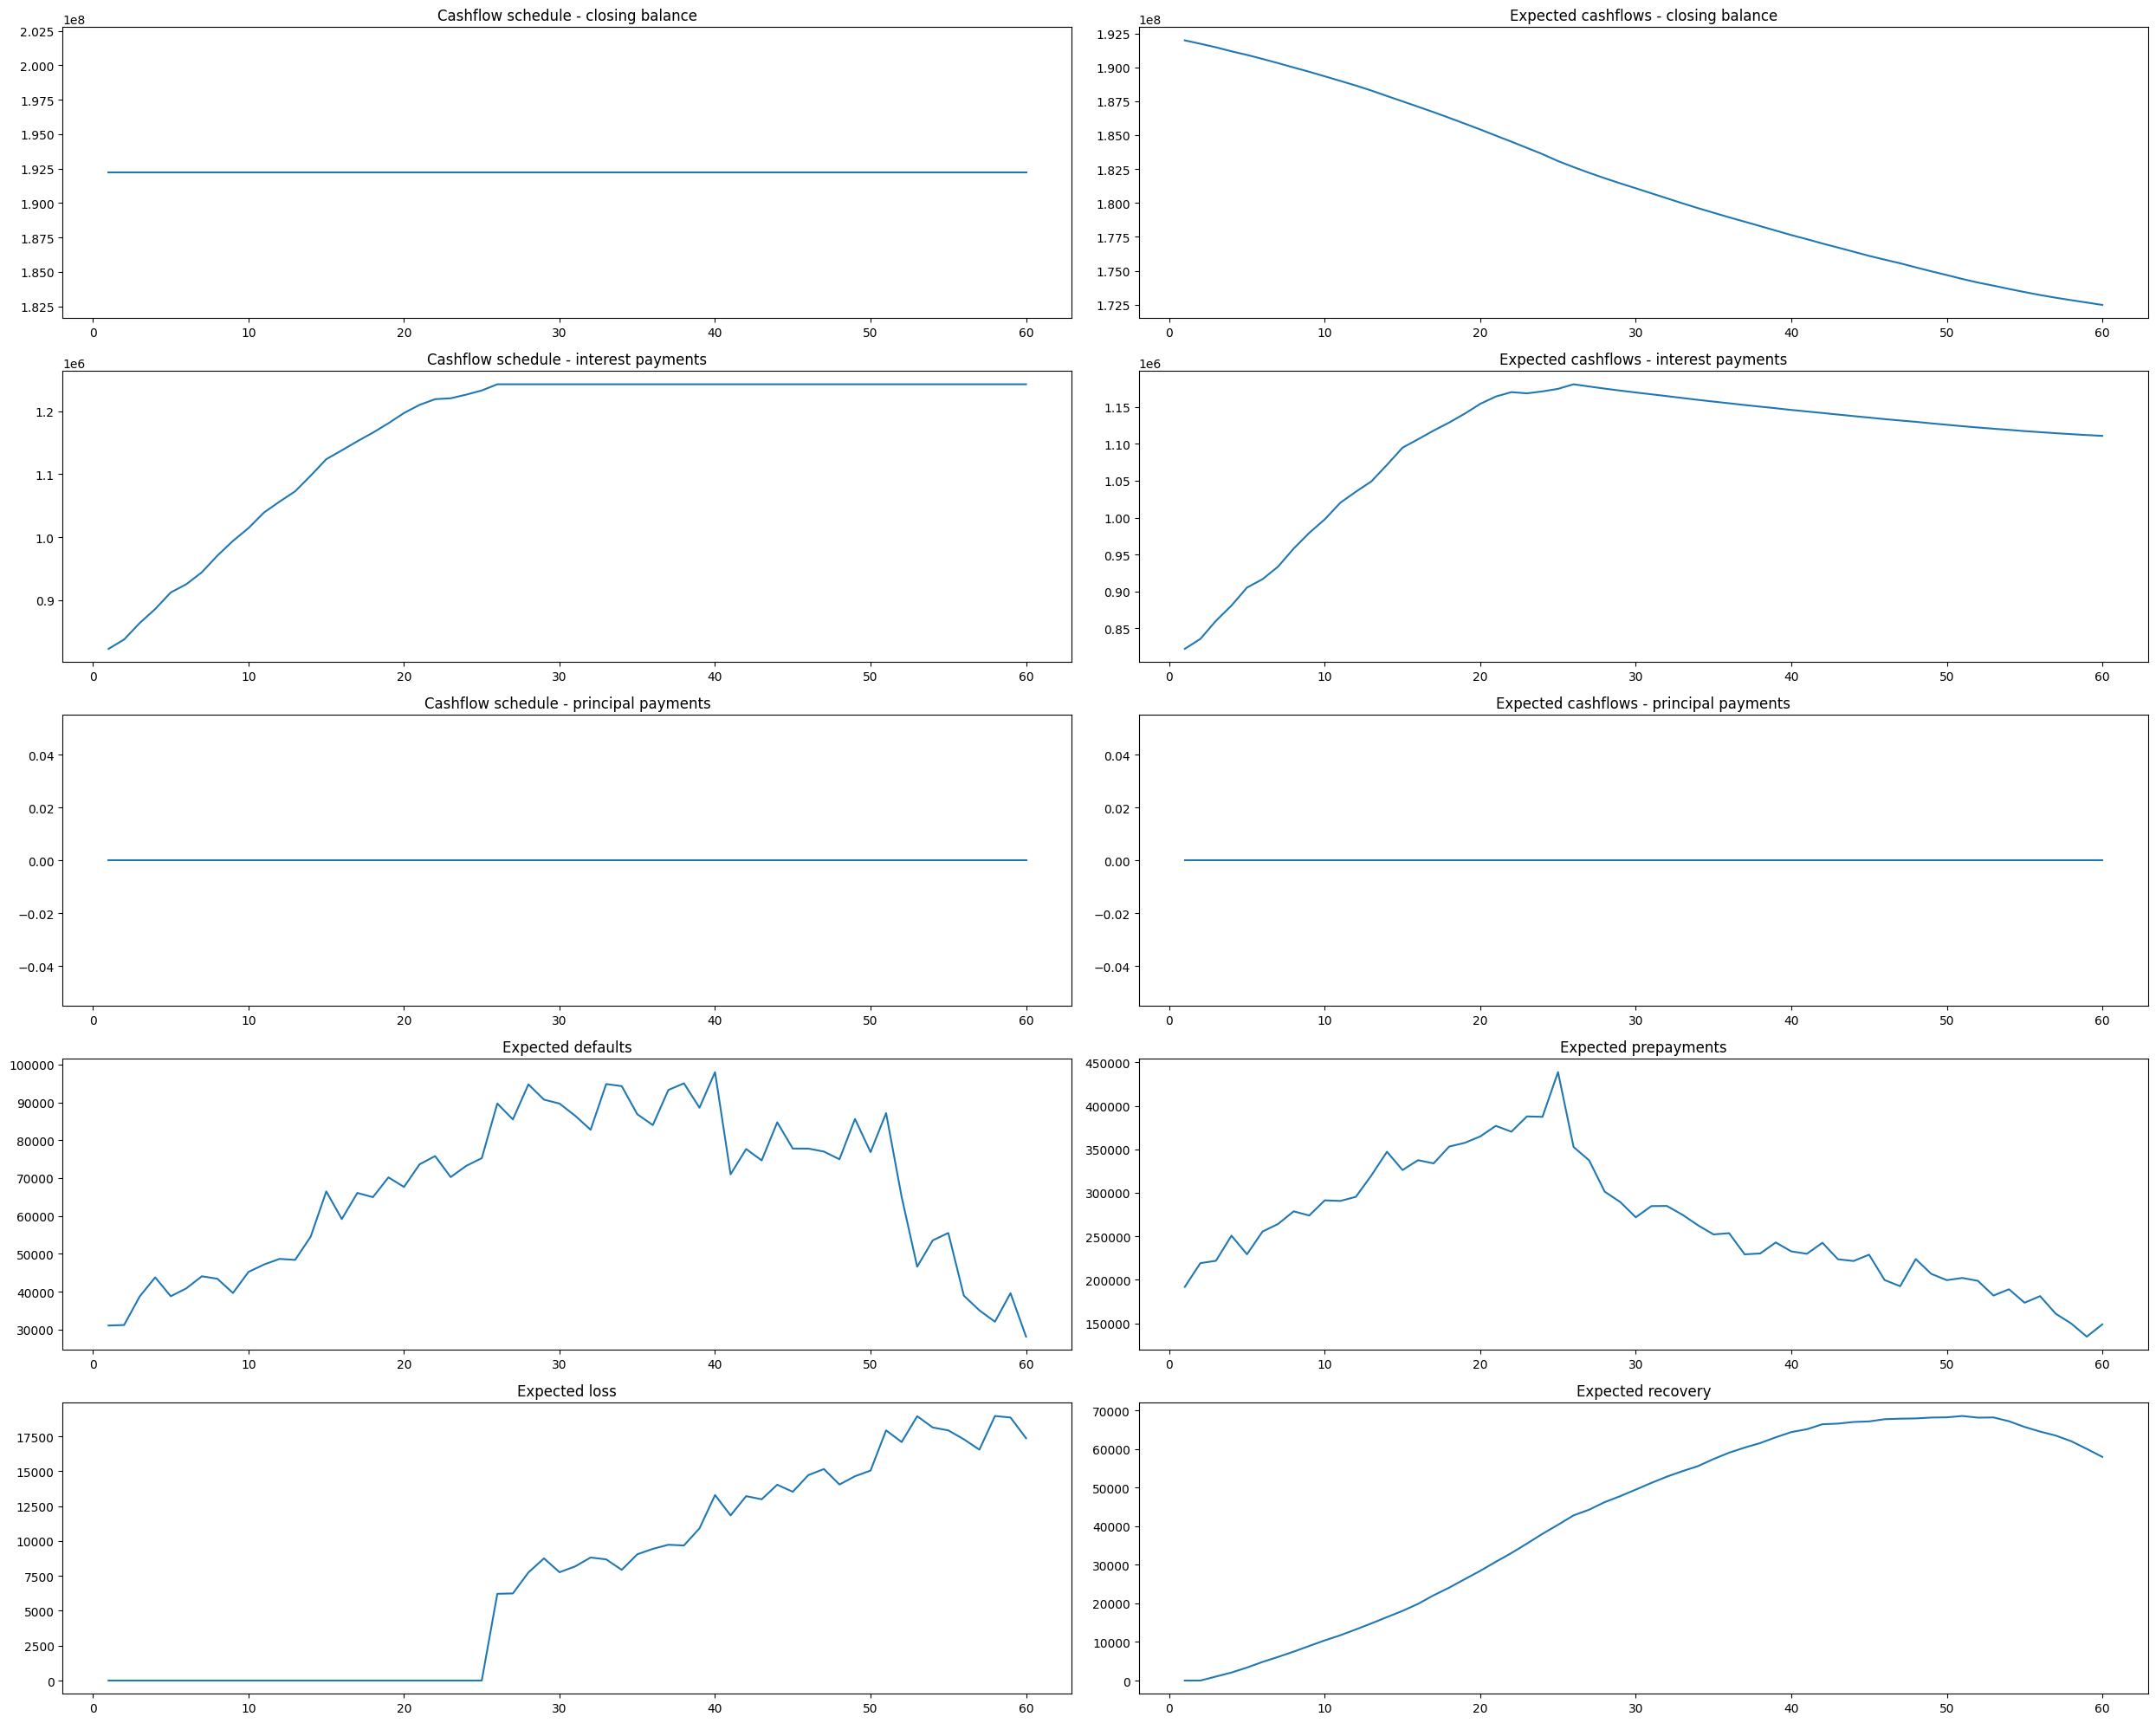

In [21]:
# plot results of forecast

plot_forecast_results(cashflow_schedule, expected_cashflows, expected_defaults)

## Sanity Checking/Performance/Further Development

### Sanity Checking

The two main sanity checks that I have performed on the forecasts are:
1. comparing the output for my model to the single loan example in the spreadsheet (you can see this code commented out in `common/forecasting.py`)
2. trying a variety of scenarios, including the above, and checking that aggregate cashflows are in line with my expectations (and that changes from the base scenario give rise to expected changes in the cashflow profile)

Error checking in the code is limited, and an important point for future development would be to improve this. Such error checking could include:
1. checks on the validity of inputs, for example that all percentages are between 0 and 1, or that the sum of the recovery curve % does not exceed 100%
2. formally codifying some of the sense checks in the above scenarios, eg the loan balance is monotonically decreasing or that defaults/prepayments look sensible based on the amount outstanding
3. checking for numerical errors, for example the division by zero warnings that can be raised in the pmt function

### Performance

Having written the code in a vectorized way, the above scenario runs generally take 1-2s. I have tested the code with loan books up to ~10,000 loans (albeit just by duplicating up the existing loan book) and out to 200 months forecast, and performance still seems to be around a few seconds. Much of the time taken is actually in the preparatory pre-forecast steps, so these could be optimized further, but for some use cases this speed may be acceptable.

All of the main numpy functions can be JIT compiled using `numba` in no-python mode - my experience for the above was that the overhead of the compilation step outweighted the benefit of doing so, and so I have not used this functionality here. However, in scenarios where we may wish to run a huge number of scenarios (eg some stochastic modelling got get a distribution of payment outcomes) this may be more valuable.

Finally, I have included an example method `run_all_forecasts` showing how python's multiprocesing module can be used to run a suite of forecasts in parallel. Again, the overhead of creating the pool of processes, context switching etc seemed to outweight the benefit here, but again if we needed to run order of magnintude more simulations then it could be useful.


### Further development

Here I have included some points for further development that I have not had time to explore:
- **scalar version of forecast** - I think the vectorized approach I have taken is fairy readable. However, a purely scalar approach designed to act on a loan-by-loan basis could be more straightforward still. The poor performance of this appraoch could be counteracted by making use of the JIT-compiled version of the functions I have written.
- **greater in-code checking** - as per the "*Sanity Checking*" section, it would be good to build more checks directly into the code. Strange behaviour on a loan-by-loan basis may get missed in the aggregation. To this end, some analysis on the overall distribution as well as aggregate forecast figures would be useful.
- **unit testing** - unit tests should be de rigueur for common library code, but I have not had time to add them here. These would be a requirement before being able to reuse this code more widely.
- **better notebook version control** - version controlling .ipynb files is challenging. I have used the library [jupytext](https://github.com/mwouts/jupytext) to this end in the past with some success, and would be keen to do so again here.